In [2]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


DataFrame for unemployment_rate:
            unemployment_rate
Date                         
1990-01-01                4.8
1990-02-01                5.0
1990-03-01                4.6
1990-04-01                4.6
1990-05-01                4.6


DataFrame for unemployed:
            unemployed
Date                  
1990-01-01     81553.0
1990-02-01     84218.0
1990-03-01     78040.0
1990-04-01     78179.0
1990-05-01     78973.0


DataFrame for employed:
             employed
Date                 
1990-01-01  1606582.0
1990-02-01  1614928.0
1990-03-01  1626070.0
1990-04-01  1617142.0
1990-05-01  1626873.0


DataFrame for civilian_labor_force:
            civilian_labor_force
Date                            
1990-01-01             1688135.0
1990-02-01             1699146.0
1990-03-01             1704110.0
1990-04-01             1695321.0
1990-05-01             1705846.0


DataFrame for employment_non_farm:
            employment_non_farm
Date                           
1990-01-01        

15:32:36 - cmdstanpy - INFO - Chain [1] start processing
15:32:36 - cmdstanpy - INFO - Chain [1] done processing


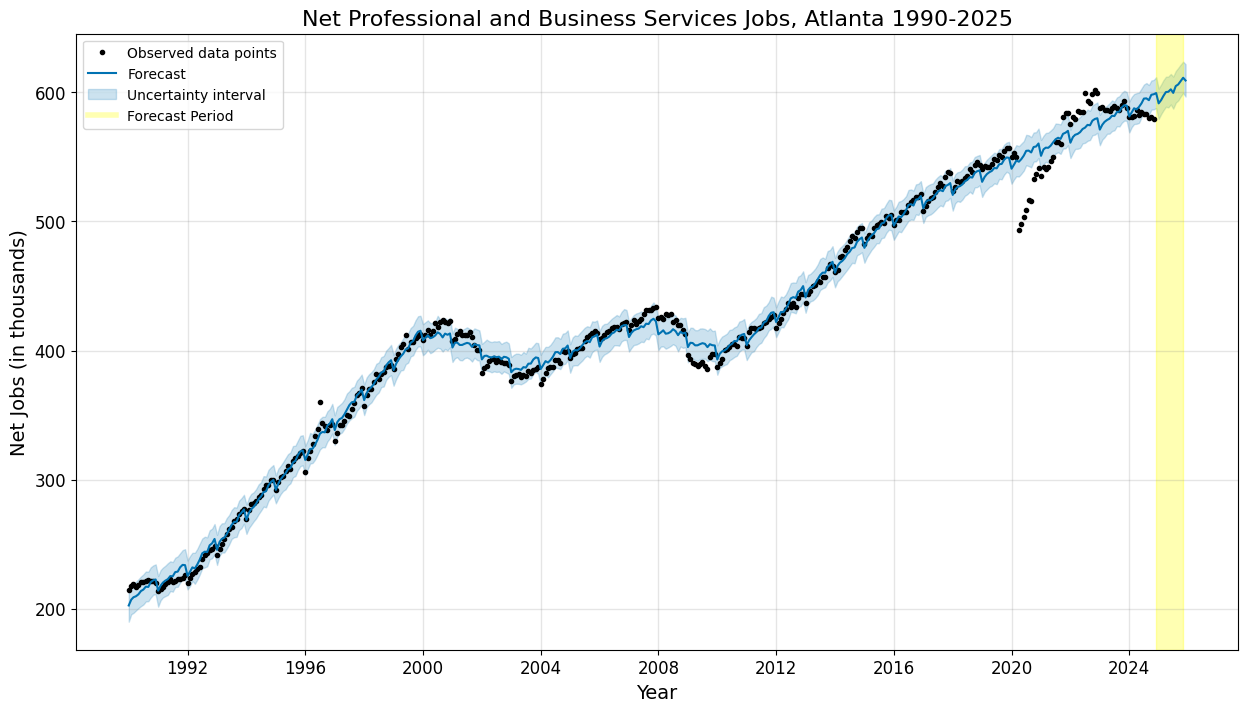

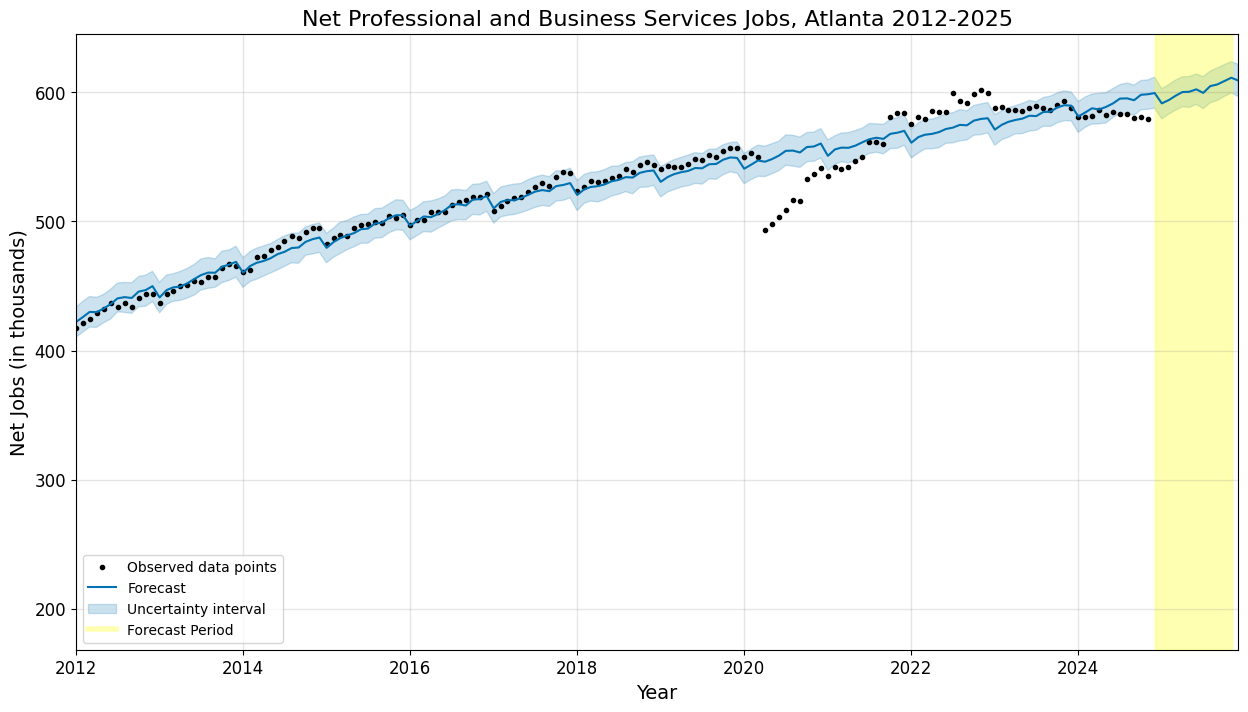

  0%|          | 0/1 [00:00<?, ?it/s]

15:32:38 - cmdstanpy - INFO - Chain [1] start processing
15:32:38 - cmdstanpy - INFO - Chain [1] done processing


          ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 2023-01-01  573.382863  562.354247  584.435337  587.7 2022-12-31
1 2023-02-01  577.434297  566.252133  589.002260  588.5 2022-12-31
2 2023-03-01  578.785736  567.898969  589.905607  586.0 2022-12-31
3 2023-04-01  580.867129  569.085712  592.313900  586.4 2022-12-31
4 2023-05-01  582.204735  570.378435  593.866686  585.2 2022-12-31
    horizon         mse       rmse        mae      mape     mdape     smape  \
0    1 days  204.980410  14.317137  14.317137  0.024361  0.024361  0.024662   
1   32 days  122.449772  11.065703  11.065703  0.018803  0.018803  0.018982   
2   60 days   52.045602   7.214264   7.214264  0.012311  0.012311  0.012387   
3   91 days   30.612663   5.532871   5.532871  0.009435  0.009435  0.009480   
4  121 days    8.971611   2.995265   2.995265  0.005118  0.005118  0.005131   
5  152 days    9.230396   3.038157   3.038157  0.005169  0.005169  0.005182   
6  182 days   26.364522   5.134639   5.134639

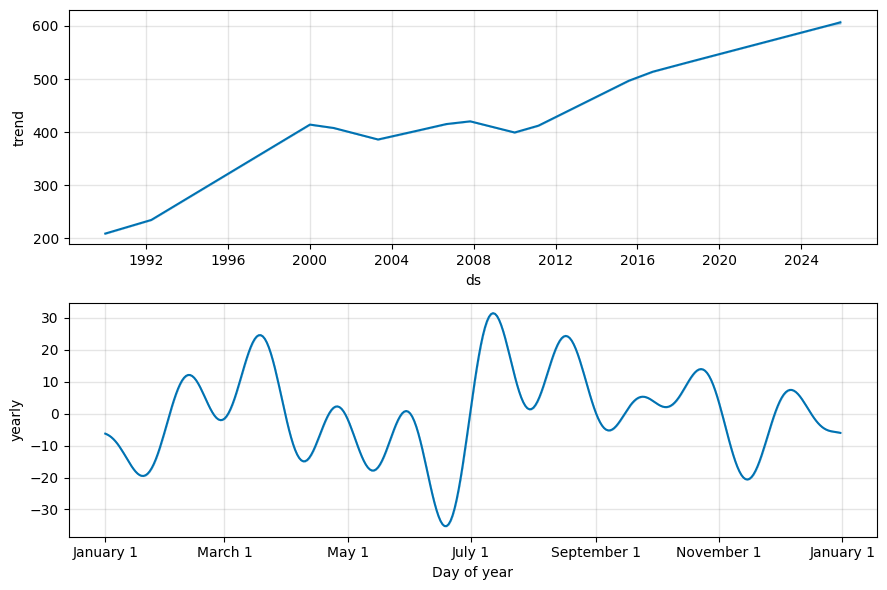

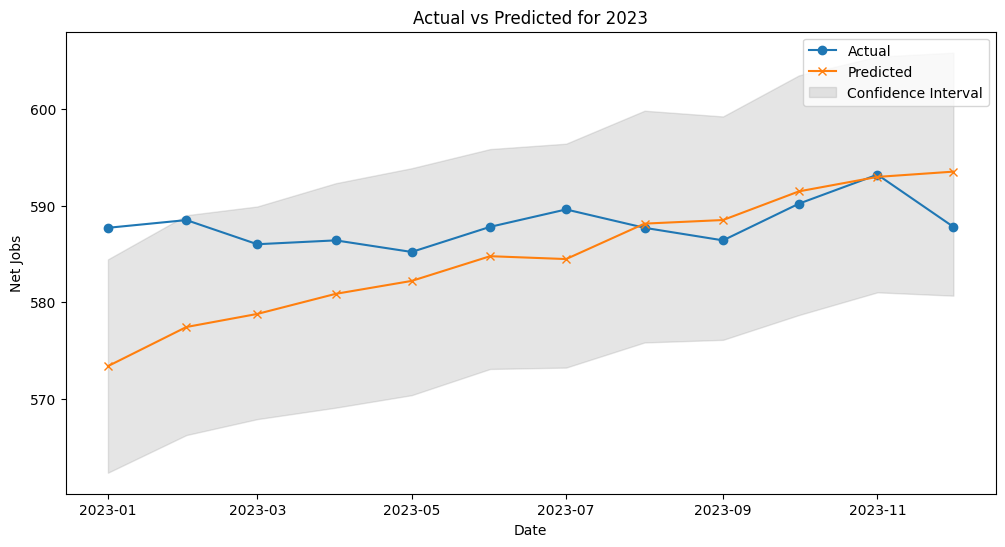

          ds      y        yhat      error  absolute_percentage_error
0 2023-01-01  587.7  573.382863  14.317137                   2.436130
1 2023-02-01  588.5  577.434297  11.065703                   1.880323
2 2023-03-01  586.0  578.785736   7.214264                   1.231103
3 2023-04-01  586.4  580.867129   5.532871                   0.943532
4 2023-05-01  585.2  582.204735   2.995265                   0.511836
Overall MAPE: 0.84%


In [91]:
import pycaret
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

pycaret.__version__

### Define the dictionary
data_dict = {
    'LAUMT131206000000006': 'civilian_labor_force',
    'LAUMT131206000000005': 'employed',
    'LAUMT131206000000004': 'unemployed',
    'LAUMT131206000000003': 'unemployment_rate',
    'SMU13120600000000001': 'employment_non_farm',
    'SMU13120602000000001': 'employment_construction',
    'SMU13120603000000001': 'employment_manufacturing',
    'SMU13120604000000001': 'employment_trade_transport_utilities',
    'SMU13120605000000001': 'employment_information',
    'SMU13120605500000001': 'employment_financial',
    'SMU13120606000000001': 'employment_professional_business_services',
    'SMU13120606500000001': 'employment_education_health',
    'SMU13120609000000001': 'employment_government',
}

### Create the process file and data function

# get the time series data

def process_file(file_path):
    # Load the dataset
    df = pd.read_excel(file_path)

    # Extract the file name without extension
    file_name = file_path.split('/')[-1].split('.')[0]

    # Get the variable name from data_dict
    variable_name = data_dict[file_name]

    # Check if 'Year' column exists
    if 'Year' not in df.columns:
        raise KeyError(f"'Year' column is not present in the DataFrame for {file_name}")

    # Melt the dataframe to long format
    df_melted = df.melt(id_vars=['Year'], var_name='Month', value_name='Value')

    # Create a datetime column
    df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'] + '-01')

    # Drop the Year and Month columns
    df_melted.drop(columns=['Year', 'Month'], inplace=True)

    # Sort by Date
    df_melted.sort_values(by='Date', inplace=True)

    # Set the Date as the index
    df_melted.set_index('Date', inplace=True)

    # Rename the Value column using data_dict
    df_melted.rename(columns={'Value': variable_name}, inplace=True)

    # Assign the dataframe to a variable named df_<variable_name>
    globals()[f'df_{variable_name}'] = df_melted

    # Show the first few rows of the dataframe
    print(f"DataFrame for {variable_name}:")
    print(globals()[f'df_{variable_name}'].head())
    print("\n")
    return globals()[f'df_{variable_name}']

def process_all_files(file_paths):
    for file_path in file_paths:
        process_file(file_path)

# List of file paths
file_paths = [
    '../data/LAUMT131206000000003.xlsx',
    '../data/LAUMT131206000000004.xlsx',
    '../data/LAUMT131206000000005.xlsx',
    '../data/LAUMT131206000000006.xlsx',
    '../data/SMU13120600000000001.xlsx',
    '../data/SMU13120602000000001.xlsx',
    '../data/SMU13120603000000001.xlsx',
    '../data/SMU13120604000000001.xlsx',
    '../data/SMU13120605000000001.xlsx',
    '../data/SMU13120605500000001.xlsx',
    '../data/SMU13120606000000001.xlsx',
    '../data/SMU13120606500000001.xlsx',
    '../data/SMU13120609000000001.xlsx',
]

# Process all files
process_all_files(file_paths)


df_employment_professional_business_services = process_file('../data/SMU13120606000000001.xlsx')
df = df_employment_professional_business_services.copy()
df = process_file('../data/SMU13120606000000001.xlsx')

### Preprocess the data

# Drop NA
df.drop(pd.to_datetime('2024-12-01'), inplace=True)
# Convert the Date column to string format
df.index = df.index.strftime('%Y-%m')

### Prepare data for Prophet

# Rename the columns to match Prophet's expected format
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'employment_professional_business_services': 'y'})

### Initialize model and make predictions

# Initialize and fit the Prophet model
m = Prophet()
m.fit(df_prophet)

# Create a DataFrame for future predictions
future = m.make_future_dataframe(periods=13, freq='M')

# Make predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

### Plot the forecast

fig1 = plt.figure(figsize=(15, 8))  # Adjusted the figure size to make it wider
ax = fig1.gca()
m.plot(forecast, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Net Jobs (in thousands)')
ax.set_title('Net Professional and Business Services Jobs, Atlanta 1990-2025')

# Highlight the forecast part from 2024-12 to 2025-11
forecast_start = pd.to_datetime('2024-12-01')
forecast_end = pd.to_datetime('2025-11-01')
ax.axvspan(forecast_start, forecast_end, color='yellow', alpha=0.3)

# Add a legend to explain the elements in the chart
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='yellow', lw=4, alpha=0.3, label='Forecast Period'))
ax.legend(handles=handles, loc='upper left')
# Increase the size of the fonts of labels and titles
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.title.set_size(16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()


### Plot the Forecast v2 - focus on specific time period

fig1 = plt.figure(figsize=(15, 8))  # Adjusted the figure size to make it wider
ax = fig1.gca()
m.plot(forecast, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Net Jobs (in thousands)')
ax.set_title('Net Professional and Business Services Jobs, Atlanta 2012-2025')

# Set the x-axis limits to zoom in on the part from 2012 to 2025
ax.set_xlim(pd.to_datetime('2012-01-01'), pd.to_datetime('2025-12-01'))

# Highlight the forecast part from 2024-12 to 2025-11
forecast_start = pd.to_datetime('2024-12-01')
forecast_end = pd.to_datetime('2025-11-01')
ax.axvspan(forecast_start, forecast_end, color='yellow', alpha=0.3)

# Add a legend to explain the elements in the chart
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='yellow', lw=4, alpha=0.3, label='Forecast Period'))
ax.legend(handles=handles, loc='lower left')

# Increase the size of the fonts of labels and titles
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.title.set_size(16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Plot the components

fig2 = m.plot_components(forecast)


### Data Analysis

# Calculate the month-on-month net change in original data
df['employment_professional_business_services_diff'] = df['employment_professional_business_services'].diff()


# Calculate the month-on-month change in yhat
forecast['yhat_diff'] = forecast['yhat'].diff()

# Filter the forecast dataset for the desired date range
jobs_2024 = df_employment_professional_business_services[(df_employment_professional_business_services.index >= '2024-01') & (df_employment_professional_business_services.index <= '2024-11')]

# Sum the employment values in the filtered dataset
net_jobs_2024 = jobs_2024['employment_professional_business_services_diff'].sum()

# Filter the forecast dataset for the desired date range
forecast_2025 = forecast[(forecast['ds'] >= '2025-01-01') & (forecast['ds'] <= '2025-11-30')]

# Sum the yhat values in the filtered dataset
sum_yhat_2025 = forecast_2025['yhat_diff'].sum()

### Check performance of the model

## Perform cross-validation

# - cutoff: Explicitly set the date to train the model up to 2022-12-31.
# - horizon: Forecast 1 year (2023).
df_cv = cross_validation(
    model=m,
    cutoffs=[pd.Timestamp('2022-12-31')],  # Cutoff ensures training data is only up to 2022-12-31
    horizon='365 days',      # Forecast 1 year ahead (2023)
    period='365 days'             
)

# View cross-validation results
print(df_cv.head())

# Calculate performance metrics for the forecast
df_performance = performance_metrics(df_cv)
print(df_performance)


## Plot actual vs predicted for the forecasted period (2023)

plt.figure(figsize=(12, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual', marker='o')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted', marker='x')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted for 2023')
plt.xlabel('Date')
plt.ylabel('Net Jobs')
plt.legend()
plt.show()

## Calculate performance metrics
df_performance = performance_metrics(df_cv)



# Add error columns to cross-validation results
df_cv['error'] = df_cv['y'] - df_cv['yhat']
df_cv['absolute_percentage_error'] = np.abs(df_cv['error'] / df_cv['y']) * 100

# Display errors for analysis
print(df_cv[['ds', 'y', 'yhat', 'error', 'absolute_percentage_error']].head())

# Add Absolute Percentage Error (APE) column to cross-validation results
df_cv['absolute_percentage_error'] = np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y']) * 100

# Calculate overall Mean Absolute Percentage Error (MAPE)
overall_mape = df_cv['absolute_percentage_error'].mean()

print(f"Overall MAPE: {overall_mape:.2f}%")


In [43]:
forecast.tail(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_diff
417,2024-10-01,595.023141,586.509352,609.376844,595.023141,595.023141,3.121064,3.121064,3.121064,3.121064,3.121064,3.121064,0.0,0.0,0.0,598.144205,4.199659
418,2024-11-01,595.881921,587.082408,610.242475,595.881921,595.881921,2.698593,2.698593,2.698593,2.698593,2.698593,2.698593,0.0,0.0,0.0,598.580515,0.436310
419,2024-11-30,596.685297,587.741185,611.011231,596.685297,596.685297,2.804101,2.804101,2.804101,2.804101,2.804101,2.804101,0.0,0.0,0.0,599.489398,0.908883
420,2024-12-31,597.544078,580.384635,602.968347,597.544078,597.544078,-6.039503,-6.039503,-6.039503,-6.039503,-6.039503,-6.039503,0.0,0.0,0.0,591.504575,-7.984823
421,2025-01-31,598.402859,582.161158,605.804713,598.402859,598.402859,-4.328876,-4.328876,-4.328876,-4.328876,-4.328876,-4.328876,0.0,0.0,0.0,594.073982,2.569407
422,2025-02-28,599.178531,586.273815,608.568337,599.172547,599.246122,-1.928419,-1.928419,-1.928419,-1.928419,-1.928419,-1.928419,0.0,0.0,0.0,597.250113,3.176130
423,2025-03-31,600.037312,589.261124,611.183114,599.903048,600.364967,0.221122,0.221122,0.221122,0.221122,0.221122,0.221122,0.0,0.0,0.0,600.258434,3.008321
424,2025-04-30,600.868390,588.741643,612.018760,600.552563,601.486553,-0.369774,-0.369774,-0.369774,-0.369774,-0.369774,-0.369774,0.0,0.0,0.0,600.498617,0.240183
425,2025-05-31,601.727171,591.019097,613.821133,601.231008,602.643344,0.656838,0.656838,0.656838,0.656838,0.656838,0.656838,0.0,0.0,0.0,602.384009,1.885393
426,2025-06-30,602.558249,587.985131,611.196566,601.839023,603.786755,-2.949145,-2.949145,-2.949145,-2.949145,-2.949145,-2.949145,0.0,0.0,0.0,599.609105,-2.774905


In [82]:
overall_mape.shape

()

In [83]:
overall_mape.mean()

0.8374959581749795

In [88]:
df_cv['absolute_percentage_error'].mean()

0.8374959581749795

In [49]:
forecast.head(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_diff
0,1990-01-01,208.723713,191.710395,214.300606,208.723713,208.723713,-6.184786,-6.184786,-6.184786,-6.184786,-6.184786,-6.184786,0.0,0.0,0.0,202.538927,NaN
1,1990-02-01,209.693818,195.965705,218.141045,209.693818,209.693818,-2.655572,-2.655572,-2.655572,-2.655572,-2.655572,-2.655572,0.0,0.0,0.0,207.038246,4.499319
2,1990-03-01,210.570041,197.944456,220.109818,210.570041,210.570041,-1.669058,-1.669058,-1.669058,-1.669058,-1.669058,-1.669058,0.0,0.0,0.0,208.900983,1.862738
3,1990-04-01,211.540146,197.997928,221.157771,211.540146,211.540146,-1.846304,-1.846304,-1.846304,-1.846304,-1.846304,-1.846304,0.0,0.0,0.0,209.693841,0.792858
4,1990-05-01,212.478957,199.443394,222.360608,212.478957,212.478957,-1.334564,-1.334564,-1.334564,-1.334564,-1.334564,-1.334564,0.0,0.0,0.0,211.144392,1.450551
5,1990-06-01,213.449061,202.905766,224.609515,213.449061,213.449061,0.252583,0.252583,0.252583,0.252583,0.252583,0.252583,0.0,0.0,0.0,213.701645,2.557252
6,1990-07-01,214.387872,203.590644,226.367407,214.387872,214.387872,0.455953,0.455953,0.455953,0.455953,0.455953,0.455953,0.0,0.0,0.0,214.843825,1.142180
7,1990-08-01,215.357977,205.420867,227.822438,215.357977,215.357977,1.744952,1.744952,1.744952,1.744952,1.744952,1.744952,0.0,0.0,0.0,217.102929,2.259104
8,1990-09-01,216.328081,204.775924,228.317712,216.328081,216.328081,0.575486,0.575486,0.575486,0.575486,0.575486,0.575486,0.0,0.0,0.0,216.903567,-0.199362
9,1990-10-01,217.266892,209.466898,232.580378,217.266892,217.266892,3.331463,3.331463,3.331463,3.331463,3.331463,3.331463,0.0,0.0,0.0,220.598355,3.694788


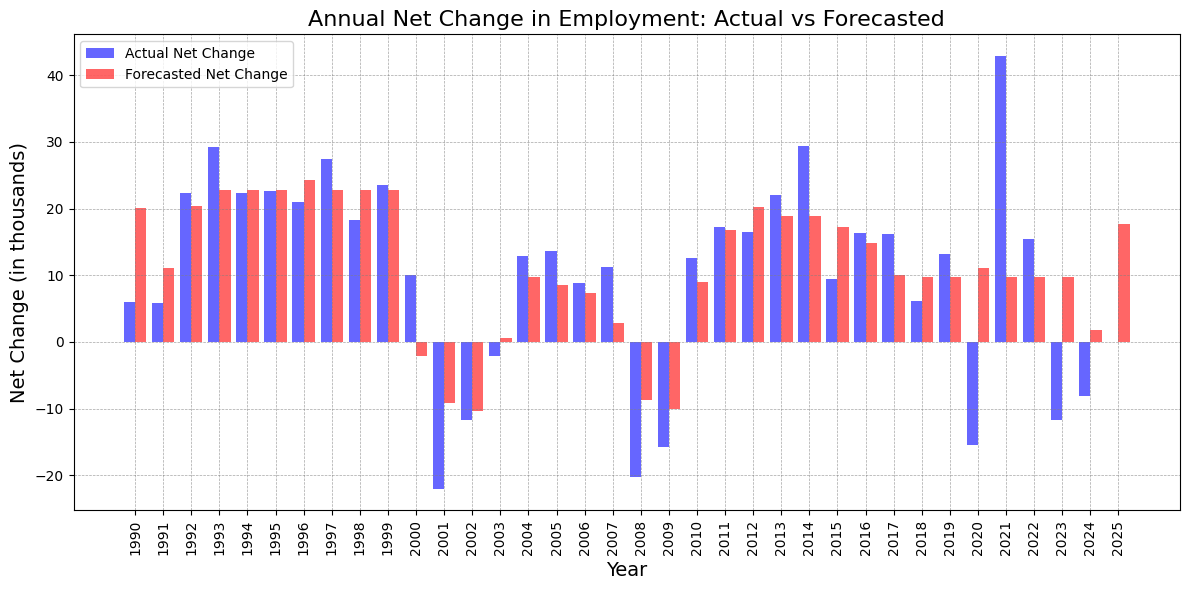

In [90]:
# Calculate the month-on-month net change in actual and forecast data
df['employment_professional_business_services_diff'] = df['employment_professional_business_services'].diff()
forecast['yhat_diff'] = forecast['yhat'].diff()

# Summarize month-to-month changes by year for both datasets
df['Year'] = pd.to_datetime(df.index).year
forecast['Year'] = pd.to_datetime(forecast['ds']).dt.year

# Aggregate the annual net change
df_annual = df.groupby('Year')['employment_professional_business_services_diff'].sum().reset_index()
forecast_annual = forecast.groupby('Year')['yhat_diff'].sum().reset_index()

# Merge actual and forecasted data for comparison
comparison = pd.merge(df_annual, forecast_annual, on='Year', how='outer', suffixes=('_actual', '_forecast'))
comparison.fillna(0, inplace=True)  # Handle missing values (if any)

# Plot the annual net changes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for actual and forecasted net change
bar1 = ax.bar(comparison['Year'] - 0.2, comparison['employment_professional_business_services_diff'], 
              width=0.4, color='blue', alpha=0.6, label='Actual Net Change')
bar2 = ax.bar(comparison['Year'] + 0.2, comparison['yhat_diff'], 
              width=0.4, color='red', alpha=0.6, label='Forecasted Net Change')

# Set x-axis ticks and labels
ax.set_xticks(comparison['Year'])
ax.set_xticklabels(comparison['Year'].astype(str), rotation=90)

# Add labels and title
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Net Change (in thousands)', fontsize=14)
ax.set_title('Annual Net Change in Employment: Actual vs Forecasted', fontsize=16)

# Add a legend
ax.legend()

# Add a light grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()


In [92]:
print(comparison[comparison['Year'] == 2023])

    Year  employment_professional_business_services_diff  yhat_diff
33  2023                                           -11.7   9.760686


In [ ]:
# Filter the forecast DataFrame for rows that are in 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025]

# Calculate the mean yhat_lower and yhat_upper for 2025
mean_yhat_lower_2025 = forecast_2025['yhat_lower'].mean()
mean_yhat_upper_2025 = forecast_2025['yhat_upper'].mean()
mean_yhat_2025 = forecast_2025['yhat'].mean()

print(f"Mean yhat_lower for 2025: {mean_yhat_lower_2025}")
print(f"Mean yhat_upper for 2025: {mean_yhat_upper_2025}")
print(f"Mean yhat: {mean_yhat_2025}")


Mean yhat_lower for 2025: 591.2280310005254
Mean yhat_upper for 2025: 615.3513315424452
Mean yhat: 603.1334698587788


In [96]:
# Filter the forecast DataFrame for rows that are in 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025]

# Calculate the mean and standard deviation of yhat for 2025
mean_yhat_2025 = forecast_2025['yhat'].mean()
std_yhat_2025 = forecast_2025['yhat'].std()

# Calculate the 95% confidence interval
confidence_interval_95 = (mean_yhat_2025 - 1.96 * std_yhat_2025, mean_yhat_2025 + 1.96 * std_yhat_2025)

print(f"Mean yhat for 2025: {mean_yhat_2025}")
print(f"Standard deviation of yhat for 2025: {std_yhat_2025}")
print(f"95% confidence interval for yhat in 2025: {confidence_interval_95}")

Mean yhat for 2025: 603.1334698587788
Standard deviation of yhat for 2025: 5.418479431987627
95% confidence interval for yhat in 2025: (592.513250172083, 613.7536895454746)


In [93]:
forecast.head(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_diff
0,1990-01-01,208.723713,189.947543,213.950085,208.723713,208.723713,-6.184786,-6.184786,-6.184786,-6.184786,-6.184786,-6.184786,0.0,0.0,0.0,202.538927,NaN
1,1990-02-01,209.693818,195.724102,218.563074,209.693818,209.693818,-2.655572,-2.655572,-2.655572,-2.655572,-2.655572,-2.655572,0.0,0.0,0.0,207.038246,4.499319
2,1990-03-01,210.570041,196.805773,219.841411,210.570041,210.570041,-1.669058,-1.669058,-1.669058,-1.669058,-1.669058,-1.669058,0.0,0.0,0.0,208.900983,1.862738
3,1990-04-01,211.540146,198.637882,220.899596,211.540146,211.540146,-1.846304,-1.846304,-1.846304,-1.846304,-1.846304,-1.846304,0.0,0.0,0.0,209.693841,0.792858
4,1990-05-01,212.478957,200.406416,222.760063,212.478957,212.478957,-1.334564,-1.334564,-1.334564,-1.334564,-1.334564,-1.334564,0.0,0.0,0.0,211.144392,1.450551
5,1990-06-01,213.449061,201.962410,224.909102,213.449061,213.449061,0.252583,0.252583,0.252583,0.252583,0.252583,0.252583,0.0,0.0,0.0,213.701645,2.557252
6,1990-07-01,214.387872,203.239314,226.559646,214.387872,214.387872,0.455953,0.455953,0.455953,0.455953,0.455953,0.455953,0.0,0.0,0.0,214.843825,1.142180
7,1990-08-01,215.357977,205.625306,228.867344,215.357977,215.357977,1.744952,1.744952,1.744952,1.744952,1.744952,1.744952,0.0,0.0,0.0,217.102929,2.259104
8,1990-09-01,216.328081,205.854289,228.656430,216.328081,216.328081,0.575486,0.575486,0.575486,0.575486,0.575486,0.575486,0.0,0.0,0.0,216.903567,-0.199362
9,1990-10-01,217.266892,208.639032,232.060050,217.266892,217.266892,3.331463,3.331463,3.331463,3.331463,3.331463,3.331463,0.0,0.0,0.0,220.598355,3.694788


In [51]:
comparison.head(15)

,Year,employment_professional_business_services_diff,yhat_diff
0,1990,6.0,20.155654
1,1991,5.9,11.071440
2,1992,22.3,20.319890
3,1993,29.2,22.848942
4,1994,22.3,22.835128
5,1995,22.6,22.821633
6,1996,21.0,24.247364
7,1997,27.4,22.848950
8,1998,18.3,22.835127
9,1999,23.5,22.821630


In [70]:
# Calculate Absolute Percentage Error (APE) for each year
comparison['APE'] = np.abs((comparison['employment_professional_business_services_diff'] - comparison['yhat_diff']) / comparison['employment_professional_business_services_diff']) * 100

# Calculate Mean Absolute Percentage Error (MAPE) for each year
comparison['MAPE'] = comparison['APE']

# Display the results
comparison[['Year', 'employment_professional_business_services_diff', 'yhat_diff', 'MAPE']]

,Year,employment_professional_business_services_diff,yhat_diff,MAPE
0,1990,6.0,20.155654,235.927571
1,1991,5.9,11.071440,87.651532
2,1992,22.3,20.319890,8.879417
3,1993,29.2,22.848942,21.750199
4,1994,22.3,22.835128,2.399679
5,1995,22.6,22.821633,0.980678
6,1996,21.0,24.247364,15.463640
7,1997,27.4,22.848950,16.609671
8,1998,18.3,22.835127,24.782115
9,1999,23.5,22.821630,2.886679


In [71]:
# drop the last row
comparison = comparison[:-1]

In [72]:
comparison.head(15)

,Year,employment_professional_business_services_diff,yhat_diff,APE,MAPE
0,1990,6.0,20.155654,235.927571,235.927571
1,1991,5.9,11.071440,87.651532,87.651532
2,1992,22.3,20.319890,8.879417,8.879417
3,1993,29.2,22.848942,21.750199,21.750199
4,1994,22.3,22.835128,2.399679,2.399679
5,1995,22.6,22.821633,0.980678,0.980678
6,1996,21.0,24.247364,15.463640,15.463640
7,1997,27.4,22.848950,16.609671,16.609671
8,1998,18.3,22.835127,24.782115,24.782115
9,1999,23.5,22.821630,2.886679,2.886679


In [ ]:
fi

In [75]:
# Calculate and print the mean MAPE excluding 2020 and 2021
print(comparison['MAPE'].median())

35.97767595533905


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:53 - cmdstanpy - INFO - Chain [1] start processing
15:27:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:54 - cmdstanpy - INFO - Chain [1] start processing
15:27:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:54 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:58 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing


    horizon         mse       rmse        mae      mape     mdape     smape  \
0   32 days  185.224006  13.609703  10.406033  0.020729  0.015908  0.021026   
1   60 days  222.941457  14.931224  12.326496  0.024494  0.022356  0.024827   
2   61 days  201.151457  14.182787  11.806796  0.023333  0.019886  0.023598   
3   91 days  247.584140  15.734807  13.189451  0.025886  0.020405  0.026212   
4   92 days  600.653564  24.508235  16.964957  0.033607  0.019186  0.033121   
5  121 days  640.804350  25.314114  18.299276  0.036364  0.023437  0.035957   
6  122 days  948.196472  30.792799  21.737746  0.043346  0.023437  0.042193   
7  152 days  601.461782  24.524718  17.902354  0.035456  0.023449  0.035133   
8  153 days  879.263536  29.652378  21.323000  0.042277  0.022933  0.041276   
9  182 days  636.964966  25.238165  18.946820  0.036988  0.022165  0.036853   
10 183 days  891.220214  29.853312  22.101713  0.043165  0.022165  0.042406   
11 213 days  605.686764  24.610704  18.088244  0.035

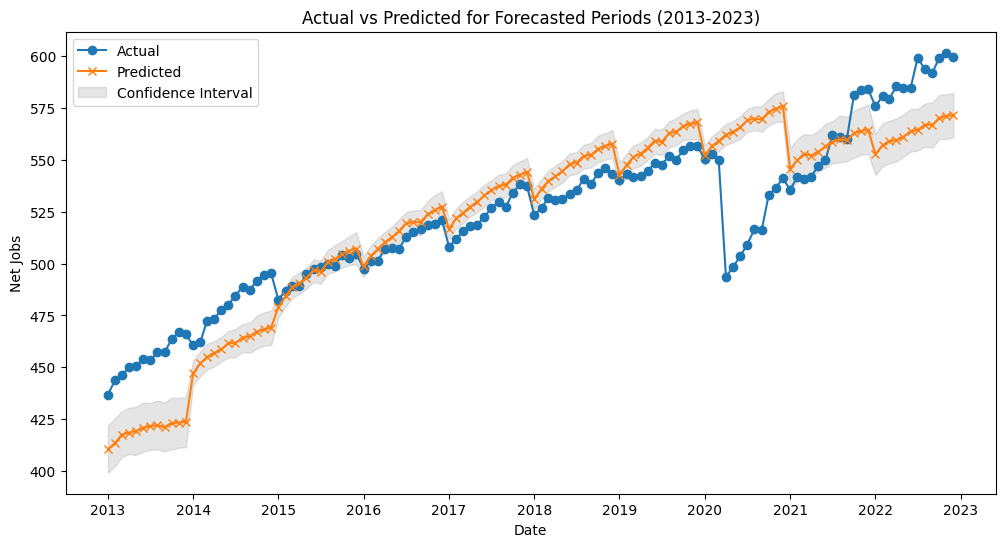

Overall MAPE: 3.28%


In [89]:
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import pandas as pd

# Define cutoffs for training up to each year from 2012 to 2022
cutoff_years = [pd.Timestamp(f"{year}-12-31") for year in range(2012, 2022)]

# Initialize a list to store cross-validation results
all_cv_results = []

# Loop through each cutoff, train up to that year, and predict the next year
for cutoff in cutoff_years:
    # Perform cross-validation for the current cutoff
    df_cv = cross_validation(
        model=m,
        cutoffs=[cutoff],
        horizon='365 days',  # Forecast 1 year ahead
        period=None          # No rolling cutoffs
    )
    all_cv_results.append(df_cv)

# Concatenate results into a single DataFrame
all_cv_results = pd.concat(all_cv_results)

# Calculate performance metrics
df_performance = performance_metrics(all_cv_results)

# Display performance metrics
print(df_performance)

# Plot actual vs predicted for all forecasted periods
plt.figure(figsize=(12, 6))
plt.plot(all_cv_results['ds'], all_cv_results['y'], label='Actual', marker='o')
plt.plot(all_cv_results['ds'], all_cv_results['yhat'], label='Predicted', marker='x')
plt.fill_between(
    all_cv_results['ds'],
    all_cv_results['yhat_lower'],
    all_cv_results['yhat_upper'],
    color='gray',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('Actual vs Predicted for Forecasted Periods (2013-2023)')
plt.xlabel('Date')
plt.ylabel('Net Jobs')
plt.legend()
plt.show()

# Add error columns to the concatenated cross-validation results
all_cv_results['error'] = all_cv_results['y'] - all_cv_results['yhat']
all_cv_results['absolute_percentage_error'] = np.abs(all_cv_results['error'] / all_cv_results['y']) * 100

# Calculate overall Mean Absolute Percentage Error (MAPE)
overall_mape = all_cv_results['absolute_percentage_error'].mean()

print(f"Overall MAPE: {overall_mape:.2f}%")
